## Fit IGM nuisance parameters to eBOSS P1D, one z at a time

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import data_Karacayli2022
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Setup an emulator (Nyx, LaCE-GP or LaCE-NN)

In [2]:
add_hires=True
if add_hires:
    emu_kmax_Mpc=8
    emu_ndeg=7
else:
    extra_data=None
    emu_kmax_Mpc=4
    emu_ndeg=5

In [3]:
emulator_label="LaCE-GP"
if emulator_label=="LaCE-GP":
#    emulator=gp_emulator.GPEmulator(training_set="Cabayol23", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
    emulator=gp_emulator.GPEmulator(training_set="Pedersen21", kmax_Mpc=emu_kmax_Mpc, ndeg=emu_ndeg)
elif emulator_label=="LaCE-NN":
    assert not add_hires,"NN emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Cabayol23", emulator_label="Cabayol23")
elif args.emulator_label=="Nyx":
    assert not add_hires,"Nyx emulator not trained beyond k=4 1/Mpc"
    emulator=nn_emulator.NNEmulator(training_set="Nyx23", emulator_label="Cabayol23_Nyx")
else:
    raise ValueError("wrong emulator_label",emulator_label)

Selected training set from Pedersen21
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.64 seconds


### Specify likelihood parameters (IGM only)

In [4]:
free_cosmo=False
if free_cosmo:
    # stick to primordial power-law parameters here
    free_param_names=["As","ns"]
else:
    free_param_names=[]
# specify the number of free parameters per IGM function (default=2)
n_igm=1
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))
# add metal line contaminations
free_param_names.append('ln_SiIII_0')

In [5]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0

### For each redshift bin / range, setup data and likelihood

In [6]:
def get_minimizer(zmin=2.7,zmax=3.3,make_plots=False):
    # set up eBOSS data
    data=data_Chabanier2019.P1D_Chabanier2019(zmin=zmin,zmax=zmax)
    if make_plots:
        data.plot_p1d()
    # Set up high-res extra data (P1D measurement from Karacayli et al. 2022)
    if add_hires:
        extra_data=data_Karacayli2022.P1D_Karacayli2022(zmin=zmin,zmax=zmax)
        if make_plots:
            extra_data.plot_p1d()
    else:
        extra_data=None
    # set up theory and likelihood
    theory=lya_theory.Theory(zs=data.z,emulator=emulator,free_param_names=free_param_names)
    like=likelihood.Likelihood(data=data,
                            theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor,
                            extra_p1d_data=extra_data)
    # set up minimizer and find best-fit values 
    minimizer = iminuit_minimizer.IminuitMinimizer(like)
    minimizer.minimize(compute_hesse=True)
    if make_plots:
        # get best-fit values
        best_fit_values=np.array(minimizer.minimizer.values)
        minimizer.plot_best_fit(residuals=True)
        if add_hires:
            like.extra_p1d_like.plot_p1d(values=best_fit_values,residuals=False)
    
    return minimizer

In [7]:
zlims=np.linspace(2.1,4.5,13)
Nz=len(zlims)-1
runs=[]
for iz in range(Nz):
    runs.append(get_minimizer(zmin=zlims[iz],zmax=zlims[iz+1],make_plots=False))

Nz = 15 , Nk = 21
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 15 , Nk = 21
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 15 , Nk = 21
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 15 , Nk = 21
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 15 , Nk = 21
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 15 , Nk = 21
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 15 , Nk = 21
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working with real data
Nz = 15 , Nk = 21
metal tag ln_SiIII
will not store truth, working with real data
will not store truth, working

In [8]:
zs=[]
mF=[]
T0=[]
gamma=[]
sigT_kms=[]
kF_kms=[]
f_SiIII=[]
for run in runs:
    best_fit_values=np.array(run.minimizer.values)
    like=run.like
    z=like.data.z[0]
    print(z,'z',best_fit_values)
    zs.append(z)
    like_params=like.parameters_from_sampling_point(best_fit_values)
    F_model = like.theory.F_model_fid.get_new_model(like_params)
    T_model = like.theory.T_model_fid.get_new_model(like_params)
    P_model = like.theory.P_model_fid.get_new_model(like_params)
    X_model = like.theory.metal_models[0].get_new_model(like_params)
    mF.append(F_model.get_mean_flux(z=z))
    T0.append(T_model.get_T0(z=z))
    sigT_kms.append(T_model.get_sigT_kms(z=z))
    gamma.append(T_model.get_gamma(z=z))
    kF_kms.append(P_model.get_kF_kms(z=z))
    f_SiIII.append(X_model.get_amplitude(z=z))

2.2 z [9.51221033e-01 6.26361800e-01 9.84867999e-01 1.58105964e-04
 6.01182140e-01]
2.4 z [0.94165763 0.6992948  0.9773903  0.22458873 0.70231976]
2.6 z [0.64096281 0.718553   0.94162767 0.35820592 0.68794382]
2.8 z [0.38493395 0.75573527 0.86433187 0.41338713 0.73798615]
3.0 z [0.26803477 0.76458694 0.87195678 0.42682864 0.72922135]
3.2 z [0.11025303 0.78144557 0.82095507 0.4162433  0.73327284]
3.4 z [0.03629452 0.78562308 0.81925471 0.38919135 0.71038441]
3.6 z [2.70810867e-04 7.99529412e-01 8.26038970e-01 3.58675416e-01
 7.05698709e-01]
3.8 z [0.01077495 0.83536771 0.8401756  0.33637872 0.72229477]
4.0 z [0.42592819 0.76050116 0.99999946 0.12321748 0.82515409]
4.2 z [0.27686121 0.90698005 0.82902814 0.19271783 0.71455656]
4.4 z [0.99912877 0.89685883 0.0951548  0.30798039 0.78753056]


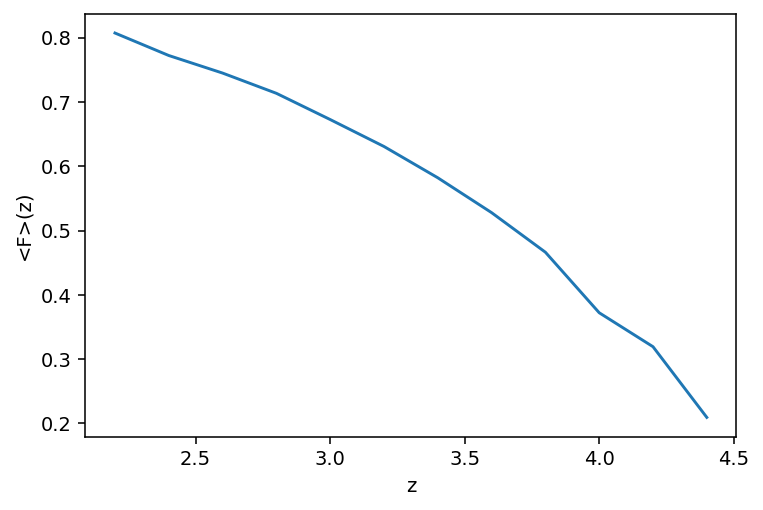

In [9]:
plt.plot(zs,mF)
plt.xlabel('z')
plt.ylabel('<F>(z)')
plt.savefig('eBOSS_HR_mF.png')

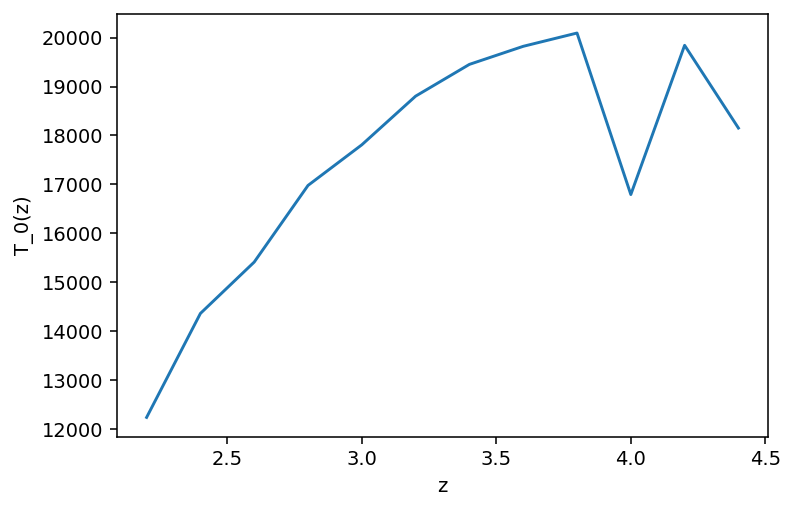

In [10]:
plt.plot(zs,T0)
plt.xlabel('z')
plt.ylabel('T_0(z)')
plt.savefig('eBOSS_HR_T0.png')

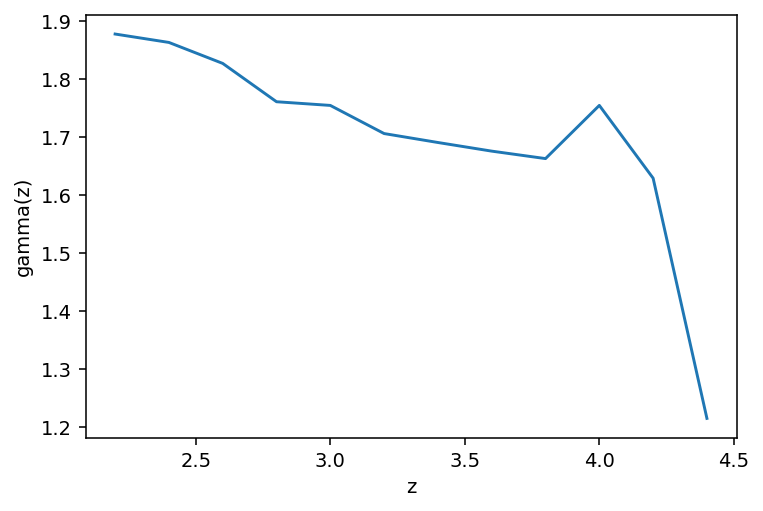

In [11]:
plt.plot(zs,gamma)
plt.xlabel('z')
plt.ylabel('gamma(z)')
plt.savefig('eBOSS_HR_gamma.png')

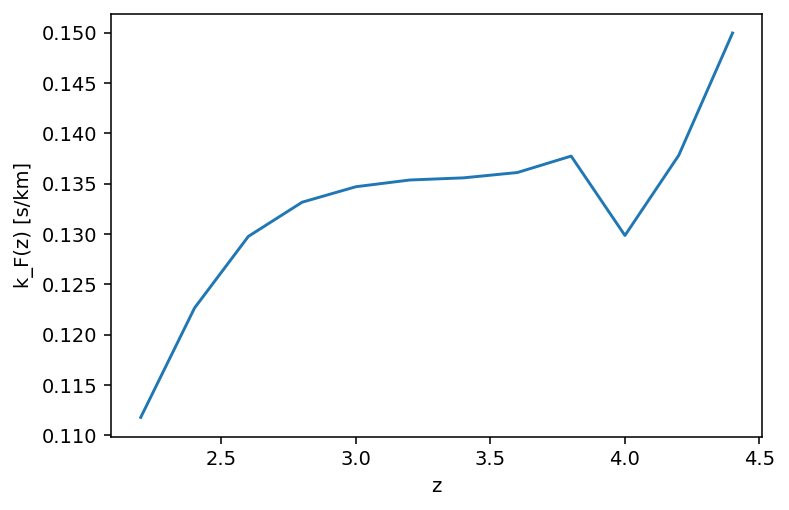

In [12]:
plt.plot(zs,kF_kms)
plt.xlabel('z')
plt.ylabel('k_F(z) [s/km]')
plt.savefig('eBOSS_HR_kF.png')

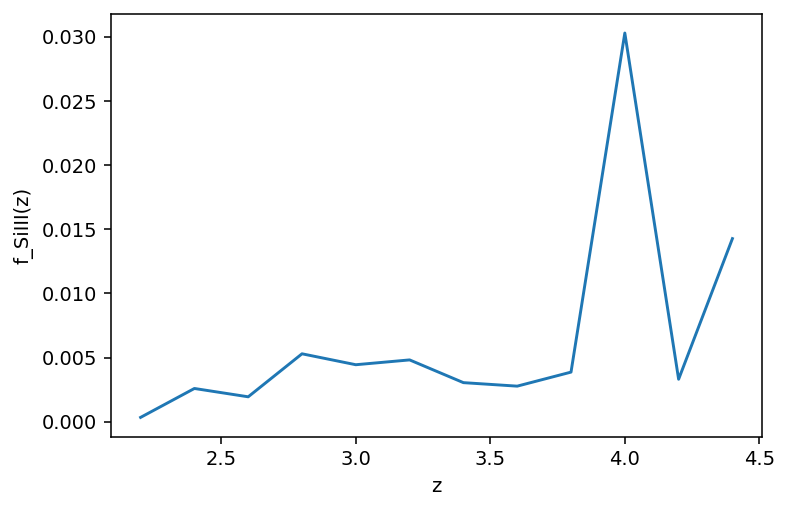

In [13]:
plt.plot(zs,f_SiIII)
plt.xlabel('z')
plt.ylabel('f_SiIII(z)')
plt.savefig('eBOSS_HR_SiIII.png')